Vocab size: 37
✅ Contextual embeddings shape: torch.Size([10, 5, 64])
✅ Attention weight tensor shape: torch.Size([10, 4, 5, 5])


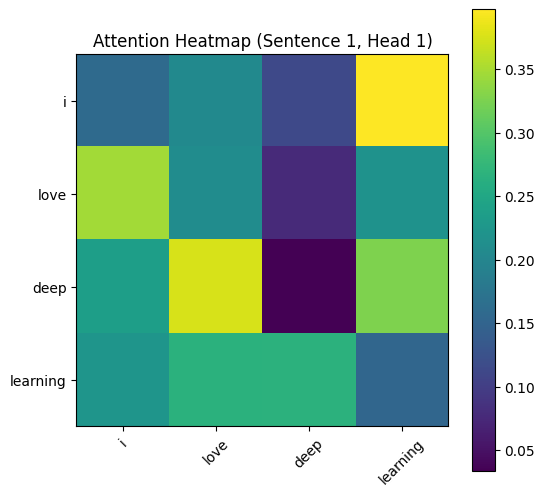


Input tokens: ['i', 'love', 'deep', 'learning']

Contextual embedding (first sentence):
 tensor([[ 4.1198e-01,  1.3295e+00,  7.2702e-01,  7.1822e-01, -1.2424e+00,
         -3.5839e-01, -1.6053e+00, -4.9028e-01, -2.5618e-03,  4.4152e-01,
         -1.0187e+00,  9.3943e-01, -1.0295e+00, -2.1757e-01, -8.5142e-01,
          9.8412e-01, -8.0626e-01,  2.2173e-02, -6.3579e-01,  3.6296e-01,
         -8.9802e-02,  3.1727e-01, -1.7318e+00, -2.5691e-02, -8.5976e-01,
         -1.0993e+00,  9.2545e-01,  2.0128e-01, -5.0760e-01, -1.5551e-01,
         -8.9596e-01,  1.5046e+00, -9.3867e-01,  1.0048e+00, -4.6302e-01,
          1.3686e+00, -1.0244e+00,  4.7613e-01,  1.6818e+00,  2.0406e+00,
         -1.0377e+00,  3.6062e-01, -4.1294e-01, -1.0494e+00, -6.1096e-01,
         -7.5623e-01, -1.2030e+00, -1.2678e-01,  9.4393e-01,  5.7347e-01,
         -1.1328e+00,  5.6859e-01, -1.7203e+00,  1.5177e+00, -1.0523e+00,
         -3.2460e-01, -8.1067e-01,  7.1879e-01, -1.6319e-01,  3.0867e-01,
          7.7597e-01, 

In [3]:
# ============================================
# 🧠 Q2. Mini Transformer Encoder for Sentences
# ============================================

!pip install torch matplotlib --quiet
import torch, torch.nn as nn, math, matplotlib.pyplot as plt

# --------------------------------------------
# 1️⃣ Data preparation
# --------------------------------------------
sentences = [
    "i love deep learning",
    "transformers are powerful",
    "attention is all you need",
    "nlp is fun",
    "pytorch makes it easy",
    "the model learns patterns",
    "language models are cool",
    "machine learning is amazing",
    "rnn and lstm remember context",
    "we build a mini transformer"
]

tokens = [s.split() for s in sentences]
vocab = sorted(set(sum(tokens, [])))
tok2id = {w: i for i, w in enumerate(vocab)}
id2tok = {i: w for w, i in tok2id.items()}

max_len = max(len(t) for t in tokens)
ids = [[tok2id[w] for w in t] + [0]*(max_len - len(t)) for t in tokens]
inputs = torch.tensor(ids)
vocab_size = len(vocab)
print(f"Vocab size: {vocab_size}")

# --------------------------------------------
# 2️⃣ Positional Encoding
# --------------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self, x): return x + self.pe[:, :x.size(1)]

# --------------------------------------------
# 3️⃣ Transformer Encoder Layer
# --------------------------------------------
class MiniEncoderLayer(nn.Module):
    def __init__(self, d_model=64, n_heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Linear(128, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
    def forward(self, x):
        attn_out, attn_weights = self.attn(x, x, x, need_weights=True, average_attn_weights=False)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x, attn_weights  # shape: (batch, heads, seq, seq)

# --------------------------------------------
# 4️⃣ Build model
# --------------------------------------------
d_model = 64
embed = nn.Embedding(vocab_size, d_model)
pos_enc = PositionalEncoding(d_model)
encoder = MiniEncoderLayer(d_model=d_model, n_heads=4)

# Forward pass
x = embed(inputs)
x = pos_enc(x)
contextual, attn_weights = encoder(x)

print("✅ Contextual embeddings shape:", contextual.shape)
print("✅ Attention weight tensor shape:", attn_weights.shape)  # (batch, heads, seq, seq)

# --------------------------------------------
# 5️⃣ Visualize attention (Fixed)
# --------------------------------------------
def plot_attention(sentence_idx=0, head_idx=0):
    # attn_weights shape: (batch, heads, seq, seq)
    attn = attn_weights[sentence_idx, head_idx].detach().cpu().numpy()
    token_list = tokens[sentence_idx]
    seq_len = len(token_list)

    plt.figure(figsize=(6,6))
    plt.imshow(attn[:seq_len, :seq_len], cmap='viridis')
    plt.xticks(range(seq_len), token_list, rotation=45)
    plt.yticks(range(seq_len), token_list)
    plt.title(f"Attention Heatmap (Sentence {sentence_idx+1}, Head {head_idx+1})")
    plt.colorbar()
    plt.show()

plot_attention(sentence_idx=0, head_idx=0)

# --------------------------------------------
# 6️⃣ Outputs
# --------------------------------------------
print("\nInput tokens:", tokens[0])
print("\nContextual embedding (first sentence):\n", contextual[0])
